#### Vivian Xia

## Assignment 3: Regression Based Models




In [ ]:
import math
import pandas as pd
import numpy as np
from operator import itemgetter


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics


from sklearn import tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings("ignore")

In [ ]:
sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
TARGET_FLAG = 'TARGET_BAD_FLAG'
TARGET_LOSS = 'TARGET_LOSS_AMT'

In [ ]:
df = pd.read_csv('HMEQ_Loss.csv')
df.head().T

,0,1,2,3,4
TARGET_BAD_FLAG,1,1,1,1,0
TARGET_LOSS_AMT,641,1109,767,1425,NaN
LOAN,1100,1300,1500,1500,1700
MORTDUE,25860,70053,13500,NaN,97800
VALUE,39025,68400,16700,NaN,112000
REASON,HomeImp,HomeImp,HomeImp,NaN,HomeImp
JOB,Other,Other,Other,NaN,Office
YOJ,10.5,7,4,NaN,3
DEROG,0,0,0,NaN,0
DELINQ,0,2,0,NaN,0


### EDA and Fill in Missing Values
Simplified version of Assignment 1

In [ ]:
dt = df.dtypes
x = df.describe().T 
print(x)

                  count           mean           std          min  \
TARGET_BAD_FLAG  5960.0       0.199497      0.399656     0.000000   
TARGET_LOSS_AMT  1189.0   13414.576955  10839.455965   224.000000   
LOAN             5960.0   18607.969799  11207.480417  1100.000000   
MORTDUE          5442.0   73760.817200  44457.609458  2063.000000   
VALUE            5848.0  101776.048741  57385.775334  8000.000000   
YOJ              5445.0       8.922268      7.573982     0.000000   
DEROG            5252.0       0.254570      0.846047     0.000000   
DELINQ           5380.0       0.449442      1.127266     0.000000   
CLAGE            5652.0     179.766275     85.810092     0.000000   
NINQ             5450.0       1.186055      1.728675     0.000000   
CLNO             5738.0      21.296096     10.138933     0.000000   
DEBTINC          4693.0      33.779915      8.601746     0.524499   

                          25%           50%            75%            max  
TARGET_BAD_FLAG      0.000

In [ ]:
#classiify variables into list based on their datatype
objList = []
intList = []
floatList = []

for i in dt.index:
  if i in ([TARGET_FLAG, TARGET_LOSS]) : continue 
  if dt[i] in (["object"]): objList.append(i)
  if dt[i] in (["float64"]): floatList.append(i)
  if dt[i] in (["int64"]): intList.append(i)


print("-- OBJECTS --")
for i in objList:
  print(i)
print("\n")

print("-- INTEGER --")
for i in intList: 
  print(i)
print("\n")

print("-- FLOAT --")
for i in floatList: 
  print(i)
print("\n")

-- OBJECTS --
REASON
JOB


-- INTEGER --
LOAN


-- FLOAT --
MORTDUE
VALUE
YOJ
DEROG
DELINQ
CLAGE
NINQ
CLNO
DEBTINC




In [ ]:
#create new variable with filled in "MISSING" value for NaN values 
for i in objList :
    if df[i].isna().sum() == 0 : continue
    NAME = "IMP_"+i
    df[NAME] = df[i]
    df[NAME] = df[NAME].fillna("MISSING")
    g = df.groupby( NAME )
    df = df.drop( i, axis=1 )

In [ ]:
#create a new list of categorical and numerical variables
dt = df.dtypes
objList = []
numList = []
for i in dt.index :
    if i in ( [ TARGET_FLAG, TARGET_LOSS ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )
    if dt[i] in (["float64","int64"]) : numList.append( i )


print(" OBJECTS ")
print(" ------- ")
for i in objList :
    print( i )
print(" ------- \n\n")


print(" NUMBER ")
print(" ------- ")
for i in numList :
    print( i )
print(" ------- ")

 OBJECTS 
 ------- 
IMP_REASON
IMP_JOB
 ------- 


 NUMBER 
 ------- 
LOAN
MORTDUE
VALUE
YOJ
DEROG
DELINQ
CLAGE
NINQ
CLNO
DEBTINC
 ------- 


In [ ]:
#encode the objects IMP_REASON and IMP_JOB then drop the original columns
for i in objList :
    thePrefix = "z_" + i
    y = pd.get_dummies( df[i], prefix=thePrefix, drop_first=True ) 
    df = pd.concat( [df, y], axis=1 )
    df = df.drop( i, axis=1 )

In [ ]:
for i in numList :
    if df[i].isna().sum() == 0 : continue #if no values are missing then continue
    FLAG = "M_" + i #notes that there was a missing value here -- highly predictive to know it was missing 
    IMP = "IMP_" + i
    df[ FLAG ] = df[i].isna() + 0 #add zero and Python will know that if TRUE it's a 1 and FALSE it's a 0
    df[ IMP ] = df[ i ] #create an exact copy of the column
    df.loc[ df[IMP].isna(), IMP ] = df[i].median() #fill missing with the median of the variable
    df = df.drop( i, axis=1 )

print(df.head().T)

                                 0             1             2             3  \
TARGET_BAD_FLAG           1.000000      1.000000      1.000000      1.000000   
TARGET_LOSS_AMT         641.000000   1109.000000    767.000000   1425.000000   
LOAN                   1100.000000   1300.000000   1500.000000   1500.000000   
z_IMP_REASON_HomeImp      1.000000      1.000000      1.000000      0.000000   
z_IMP_REASON_MISSING      0.000000      0.000000      0.000000      1.000000   
z_IMP_JOB_Mgr             0.000000      0.000000      0.000000      0.000000   
z_IMP_JOB_Office          0.000000      0.000000      0.000000      0.000000   
z_IMP_JOB_Other           1.000000      1.000000      1.000000      0.000000   
z_IMP_JOB_ProfExe         0.000000      0.000000      0.000000      0.000000   
z_IMP_JOB_Sales           0.000000      0.000000      0.000000      0.000000   
z_IMP_JOB_Self            0.000000      0.000000      0.000000      0.000000   
M_MORTDUE                 0.000000      

### Remove Outliers

In [ ]:
dt = df.dtypes
numList = []
for i in dt.index :
    #print(i, dt[i])
    if i in ( [ TARGET_FLAG, TARGET_LOSS ] ) : continue
    if dt[i] in (["float64","int64"]) : numList.append( i )

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET_BAD_FLAG,5960.0,0.199497,0.399656,0.000000,0.000000,0.000000,0.000000,1.000000
TARGET_LOSS_AMT,1189.0,13414.576955,10839.455965,224.000000,5639.000000,11003.000000,17634.000000,78987.000000
LOAN,5960.0,18607.969799,11207.480417,1100.000000,11100.000000,16300.000000,23300.000000,89900.000000
z_IMP_REASON_HomeImp,5960.0,0.298658,0.457708,0.000000,0.000000,0.000000,1.000000,1.000000
z_IMP_REASON_MISSING,5960.0,0.042282,0.201248,0.000000,0.000000,0.000000,0.000000,1.000000
z_IMP_JOB_Mgr,5960.0,0.128691,0.334886,0.000000,0.000000,0.000000,0.000000,1.000000
z_IMP_JOB_Office,5960.0,0.159060,0.365763,0.000000,0.000000,0.000000,0.000000,1.000000
z_IMP_JOB_Other,5960.0,0.400671,0.490076,0.000000,0.000000,0.000000,1.000000,1.000000
z_IMP_JOB_ProfExe,5960.0,0.214094,0.410227,0.000000,0.000000,0.000000,0.000000,1.000000
z_IMP_JOB_Sales,5960.0,0.018289,0.134004,0.000000,0.000000,0.000000,0.000000,1.000000


LOAN


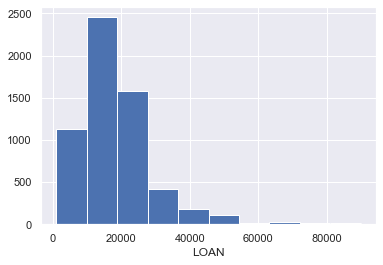

M_MORTDUE


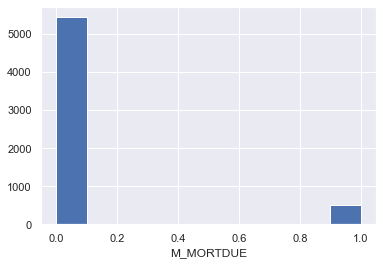

IMP_MORTDUE


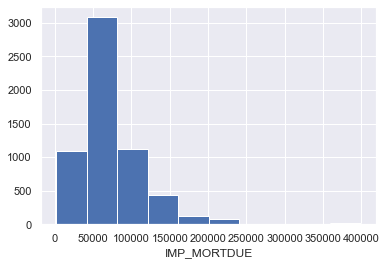

M_VALUE


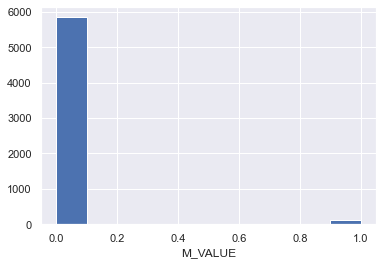

IMP_VALUE


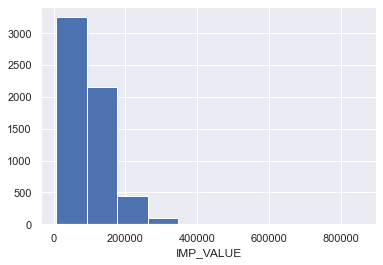

M_YOJ


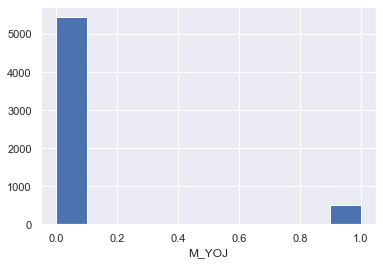

IMP_YOJ


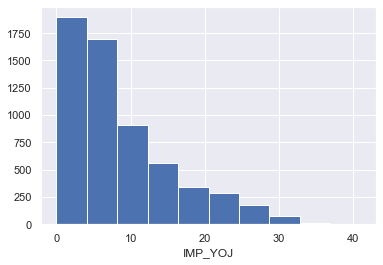

M_DEROG


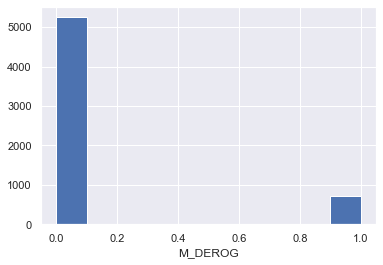

IMP_DEROG


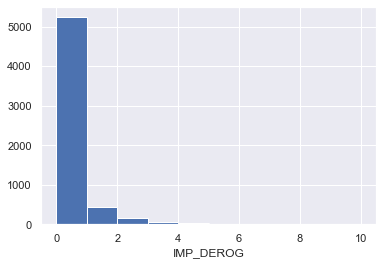

M_DELINQ


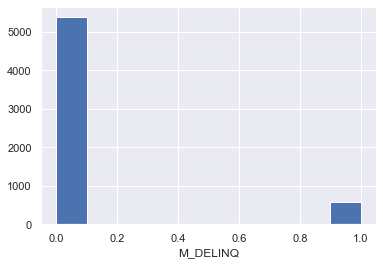

IMP_DELINQ


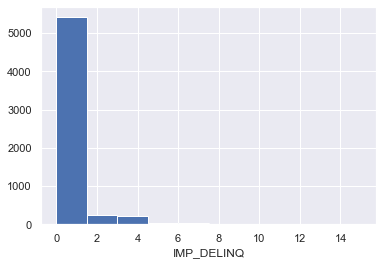

M_CLAGE


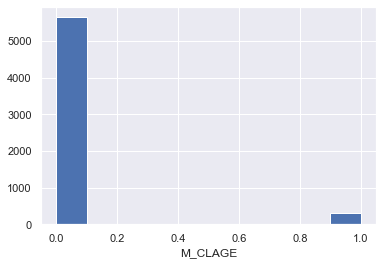

IMP_CLAGE


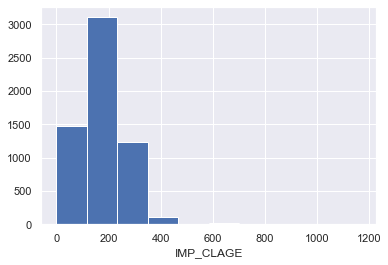

M_NINQ


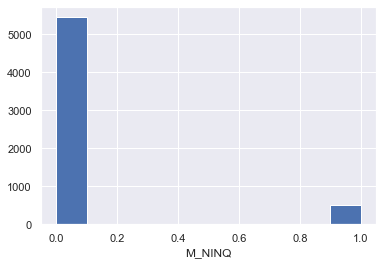

IMP_NINQ


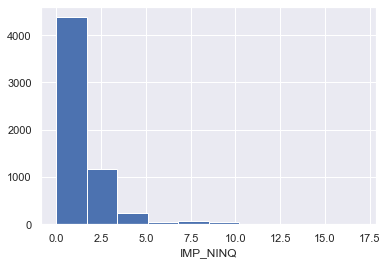

M_CLNO


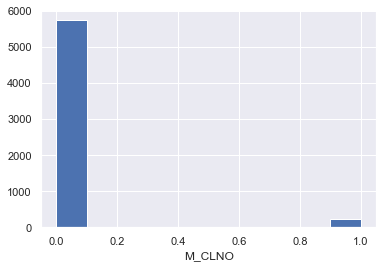

IMP_CLNO


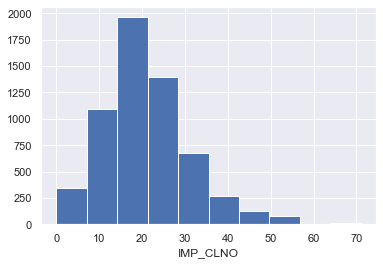

M_DEBTINC


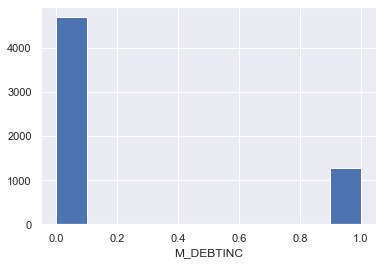

IMP_DEBTINC


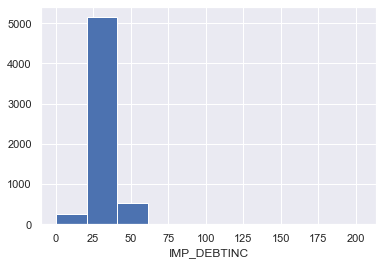

In [ ]:
for i in numList :
    print( i )
    plt.hist( df[ i ] )
    plt.xlabel( i )
    plt.show()

In [ ]:
for i in numList :
    theMean = df[i].mean()
    theSD = df[i].std()
    theMax = df[i].max()
    theCutoff = round( theMean + 3*theSD )
    if theMax < theCutoff : continue
    FLAG = "O_" + i
    TRUNC = "TRUNC_" + i
    df[ FLAG ] = ( df[i] > theCutoff )+ 0
    df[ TRUNC ] = df[ i ]
    df.loc[ df[TRUNC] > theCutoff, TRUNC ] = theCutoff
    df = df.drop( i, axis=1 )

In [ ]:
#for i in objList:
    #df = df.drop( i, axis=1 )

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET_BAD_FLAG,5960.0,0.199497,0.399656,0.000000,0.000000,0.000000,0.000000,1.0
TARGET_LOSS_AMT,1189.0,13414.576955,10839.455965,224.000000,5639.000000,11003.000000,17634.000000,78987.0
z_IMP_REASON_HomeImp,5960.0,0.298658,0.457708,0.000000,0.000000,0.000000,1.000000,1.0
z_IMP_REASON_MISSING,5960.0,0.042282,0.201248,0.000000,0.000000,0.000000,0.000000,1.0
z_IMP_JOB_Mgr,5960.0,0.128691,0.334886,0.000000,0.000000,0.000000,0.000000,1.0
z_IMP_JOB_Office,5960.0,0.159060,0.365763,0.000000,0.000000,0.000000,0.000000,1.0
z_IMP_JOB_Other,5960.0,0.400671,0.490076,0.000000,0.000000,0.000000,1.000000,1.0
z_IMP_JOB_ProfExe,5960.0,0.214094,0.410227,0.000000,0.000000,0.000000,0.000000,1.0
z_IMP_JOB_Sales,5960.0,0.018289,0.134004,0.000000,0.000000,0.000000,0.000000,1.0
z_IMP_JOB_Self,5960.0,0.032383,0.177029,0.000000,0.000000,0.000000,0.000000,1.0


### Split Data

In [ ]:
X = df.copy()
X = X.drop( TARGET_FLAG, axis=1 )
X = X.drop( TARGET_LOSS, axis=1 )

Y = df[ [TARGET_FLAG, TARGET_LOSS] ]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=1) #80% of the data for training and 20% for testing

print( "FLAG DATA" )
print( "TRAINING = ", X_train.shape )
print( "TEST = ", X_test.shape )

FLAG DATA
TRAINING =  (4768, 46)
TEST =  (1192, 46)


In [ ]:
F = ~ Y_train[TARGET_LOSS].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_LOSS ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

In [ ]:
print( Z_train.describe() )
print( Z_test.describe() ) 

       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            941.0       941.000000
mean               1.0     13421.645058
std                0.0     10662.481428
min                1.0       224.000000
25%                1.0      5817.000000
50%                1.0     10959.000000
75%                1.0     17635.000000
max                1.0     73946.000000
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            248.0       248.000000
mean               1.0     13387.758065
std                0.0     11508.703991
min                1.0       320.000000
25%                1.0      5214.500000
50%                1.0     11336.500000
75%                1.0     16734.000000
max                1.0     78987.000000


### Model Accuracy Metrics

In [ ]:
def getProbAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    probs = MODEL.predict_proba( X )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

In [ ]:
def print_ROC_Curve( TITLE, LIST ) :
    fig = plt.figure(figsize=(6,4))
    plt.title( TITLE )
    for theResults in LIST :
        NAME = theResults[0]
        fpr = theResults[2]
        tpr = theResults[3]
        auc = theResults[4]
        theLabel = "AUC " + NAME + ' %0.2f' % auc
        plt.plot(fpr, tpr, label = theLabel )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
def print_Accuracy( TITLE, LIST ) :
    print( TITLE )
    print( "======" )
    for theResults in LIST :
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "------\n\n" )

In [ ]:
def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]

### Decision Tree

In [ ]:
#seach variables for the model
def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list

#### Loan Default Probability

In [ ]:
WHO = "TREE"

CLM = tree.DecisionTreeClassifier( max_depth=4 )
CLM = CLM.fit( X_train, Y_train[ TARGET_FLAG ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_FLAG ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_FLAG ] )

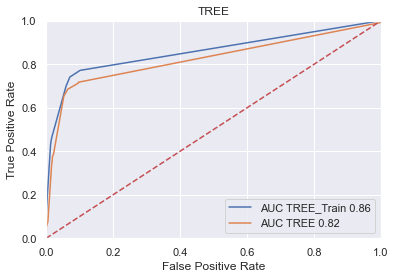

TREE CLASSIFICATION ACCURACY
TREE_Train  =  0.8928271812080537
TREE  =  0.8859060402684564
------




In [ ]:
print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

In [ ]:
feature_cols = list( X.columns.values )
tree.export_graphviz(CLM,out_file='tree_f.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, class_names=["Good","Bad"]  )
vars_tree_flag = getTreeVars( CLM, feature_cols ) 

#### Loss Amount

In [ ]:
AMT = tree.DecisionTreeRegressor( max_depth= 4 )
AMT = AMT.fit( W_train, Z_train[TARGET_LOSS] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_LOSS] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_LOSS] )

print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TREE RMSE ACCURACY
TREE_Train  =  4587.556685671267
TREE  =  5713.237610480276
------




In [ ]:
feature_cols = list( X.columns.values )
vars_tree_amt = getTreeVars( AMT, feature_cols ) 
tree.export_graphviz(AMT,out_file='tree_a.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, precision=0  )

TREE_CLM = TEST_CLM.copy()
TREE_AMT = TEST_AMT.copy()

### Random Forest

In [ ]:
def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

#### Loan Default Probability

In [ ]:
WHO = "RF"

CLM = RandomForestClassifier( n_estimators = 25, random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_FLAG ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_FLAG ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_FLAG ] )

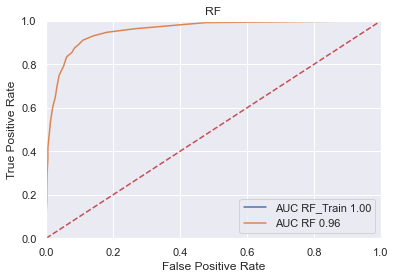

RF CLASSIFICATION ACCURACY
RF_Train  =  0.9993708053691275
RF  =  0.9119127516778524
------




In [ ]:
print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

In [ ]:
feature_cols = list( X.columns.values )
vars_RF_flag = getEnsembleTreeVars( CLM, feature_cols )

#### Loss Amount

In [ ]:
AMT = RandomForestRegressor(n_estimators = 100, random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_LOSS] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_LOSS] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_LOSS] )

print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

RF RMSE ACCURACY
RF_Train  =  1317.8895879806714
RF  =  3428.650015145327
------




In [ ]:
feature_cols = list( X.columns.values )
vars_RF_amt = getEnsembleTreeVars( AMT, feature_cols )

for i in vars_RF_amt :
    print( i )

('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 13)
('TRUNC_IMP_DEBTINC', 6)
('TRUNC_M_DEBTINC', 4)
('TRUNC_IMP_CLAGE', 3)


In [ ]:
RF_CLM = TEST_CLM.copy()
RF_AMT = TEST_AMT.copy()

### Gradient Boosting

#### Loan Default Probability

In [ ]:
WHO = "GB"

CLM = GradientBoostingClassifier( random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_FLAG ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_FLAG ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_FLAG ] )

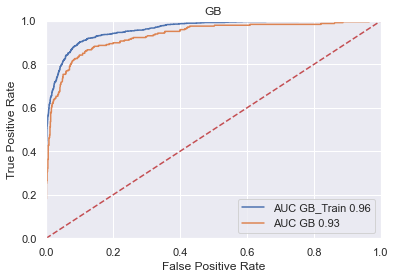

GB CLASSIFICATION ACCURACY
GB_Train  =  0.9238674496644296
GB  =  0.9060402684563759
------




In [ ]:
print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

In [ ]:
feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( CLM, feature_cols )

#### Loss Amount

In [ ]:
AMT = GradientBoostingRegressor(random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_LOSS] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_LOSS] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_LOSS] )

print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

GB RMSE ACCURACY
GB_Train  =  1245.4603241383124
GB  =  2794.947030828998
------




In [ ]:
feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( AMT, feature_cols )

for i in vars_RF_amt :
    print( i )

('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 13)
('TRUNC_IMP_DEBTINC', 6)
('TRUNC_M_DEBTINC', 4)
('TRUNC_IMP_CLAGE', 3)


In [ ]:
GB_CLM = TEST_CLM.copy()
GB_AMT = TEST_AMT.copy()

### Functions for Logit and Linear Regression Models

In [ ]:
def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    print("\nLOAN DEFAULT")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )



def getCoefLinear( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_,varNames):
        coef_dict[feat] = coef
    print("\nLOSS AMOUNT")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )

### Regression All Variables

#### Loan Default Probability

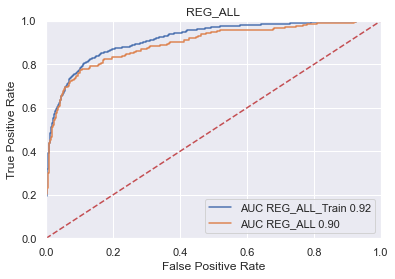

REG_ALL CLASSIFICATION ACCURACY
REG_ALL_Train  =  0.893246644295302
REG_ALL  =  0.886744966442953
------




In [ ]:
WHO = "REG_ALL"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train, Y_train[ TARGET_FLAG ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_FLAG ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_FLAG ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#### Loss Amount

In [ ]:
AMT = LinearRegression()
AMT = AMT.fit( W_train, Z_train[TARGET_LOSS] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_LOSS] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_LOSS] )

print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_ALL RMSE ACCURACY
REG_ALL_Train  =  3555.90846939125
REG_ALL  =  3615.1006384119664
------




In [ ]:
varNames = list( X_train.columns.values )

#REG_ALL_CLM_COEF = getCoefLogit( CLM, X_train )
#REG_ALL_AMT_COEF = getCoefLinear( AMT, X_train )

REG_ALL_CLM = TEST_CLM.copy()
REG_ALL_AMT = TEST_AMT.copy()

### Regression Decision Tree

#### Loan Default Probability

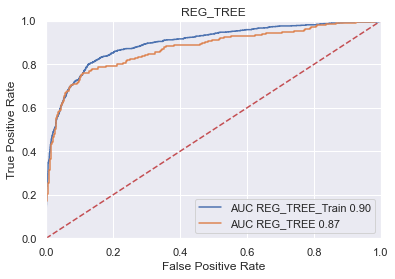

REG_TREE CLASSIFICATION ACCURACY
REG_TREE_Train  =  0.8863255033557047
REG_TREE  =  0.8800335570469798
------




In [ ]:
WHO = "REG_TREE"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[vars_tree_flag], Y_train[ TARGET_FLAG ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[vars_tree_flag], Y_train[ TARGET_FLAG ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[vars_tree_flag], Y_test[ TARGET_FLAG ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#### Loss Amount

In [ ]:
AMT = LinearRegression()
AMT = AMT.fit( W_train[vars_tree_amt], Z_train[TARGET_LOSS] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[vars_tree_amt], Z_train[TARGET_LOSS] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[vars_tree_amt], Z_test[TARGET_LOSS] )

print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_TREE RMSE ACCURACY
REG_TREE_Train  =  4416.313150464977
REG_TREE  =  5063.987350451349
------




In [ ]:
varNames = list( X_train.columns.values )

#REG_TREE_CLM_COEF = getCoefLogit( CLM, X_train[vars_tree_flag] )
#REG_TREE_AMT_COEF = getCoefLinear( AMT, X_train[vars_tree_amt] )

REG_TREE_CLM = TEST_CLM.copy()
REG_TREE_AMT = TEST_AMT.copy()

### Regression Random Forest

#### Loan Default Probability

In [ ]:
WHO = "REG_RF"

RF_flag = []
for i in vars_RF_flag :
    print(i)
    theVar = i[0]
    RF_flag.append( theVar )

print("\n\n")
RF_amt = []
for i in vars_RF_amt :
    print(i)
    theVar = i[0]
    RF_amt.append( theVar )

('TRUNC_M_DEBTINC', 100)
('TRUNC_IMP_DEBTINC', 76)
('TRUNC_IMP_CLAGE', 46)
('TRUNC_LOAN', 39)
('TRUNC_IMP_VALUE', 39)
('TRUNC_IMP_MORTDUE', 36)
('TRUNC_IMP_CLNO', 34)
('TRUNC_IMP_DELINQ', 33)
('TRUNC_IMP_YOJ', 30)
('TRUNC_IMP_DEROG', 21)
('TRUNC_IMP_NINQ', 20)
('O_M_VALUE', 14)



('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 13)
('TRUNC_IMP_DEBTINC', 6)
('TRUNC_M_DEBTINC', 4)
('TRUNC_IMP_CLAGE', 3)


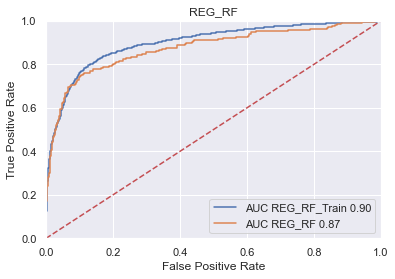

REG_RF CLASSIFICATION ACCURACY
REG_RF_Train  =  0.8800335570469798
REG_RF  =  0.87751677852349
------




In [ ]:
CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[RF_flag], Y_train[ TARGET_FLAG ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[RF_flag], Y_train[ TARGET_FLAG ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[RF_flag], Y_test[ TARGET_FLAG ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#### Loss Amount

In [ ]:
AMT = LinearRegression()
AMT = AMT.fit( W_train[RF_amt], Z_train[TARGET_LOSS] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[RF_amt], Z_train[TARGET_LOSS] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[RF_amt], Z_test[TARGET_LOSS] )

print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_RF RMSE ACCURACY
REG_RF_Train  =  4238.056494916955
REG_RF  =  4834.631645572038
------




In [ ]:
REG_RF_CLM_COEF = getCoefLogit( CLM, X_train[RF_flag] )
REG_RF_AMT_COEF = getCoefLinear( AMT, X_train[RF_amt] )

REG_RF_CLM = TEST_CLM.copy()
REG_RF_AMT = TEST_AMT.copy()


LOAN DEFAULT
---------
Total Variables:  13
INTERCEPT  =  -5.277350491799424
TRUNC_M_DEBTINC  =  2.6977038943919815
TRUNC_IMP_DEBTINC  =  0.10337974267018832
TRUNC_IMP_CLAGE  =  -0.005881064244565169
TRUNC_LOAN  =  -5.044107866009968e-06
TRUNC_IMP_VALUE  =  1.5802338406434643e-06
TRUNC_IMP_MORTDUE  =  -1.1578982148828966e-06
TRUNC_IMP_CLNO  =  -0.018749336039457866
TRUNC_IMP_DELINQ  =  0.7101946567812808
TRUNC_IMP_YOJ  =  -0.011837837969276883
TRUNC_IMP_DEROG  =  0.7205428184021219
TRUNC_IMP_NINQ  =  0.1325985504151847
O_M_VALUE  =  3.584420795677956

LOSS AMOUNT
---------
Total Variables:  6
INTERCEPT  =  -13269.322689831992
TRUNC_LOAN  =  0.7957096877509179
TRUNC_IMP_CLNO  =  295.8661953290628
TRUNC_IMP_DEBTINC  =  198.11601519151213
TRUNC_M_DEBTINC  =  5813.596604342766
TRUNC_IMP_CLAGE  =  -25.63038798406322


### Regression Gradient Boosting

#### Loan Default Probability

In [ ]:
WHO = "REG_GB"

GB_flag = []
for i in vars_GB_flag :
    print(i)
    theVar = i[0]
    GB_flag.append( theVar )

print("\n\n")
GB_amt = []
for i in vars_GB_amt :
    print(i)
    theVar = i[0]
    GB_amt.append( theVar )

('TRUNC_M_DEBTINC', 100)
('TRUNC_IMP_DEBTINC', 29)
('TRUNC_IMP_DELINQ', 16)
('TRUNC_IMP_CLAGE', 14)
('TRUNC_IMP_DEROG', 7)
('O_M_VALUE', 7)
('TRUNC_IMP_VALUE', 5)
('TRUNC_IMP_YOJ', 5)
('TRUNC_IMP_CLNO', 5)
('TRUNC_LOAN', 4)



('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 14)
('TRUNC_IMP_DEBTINC', 6)
('TRUNC_M_DEBTINC', 5)
('TRUNC_IMP_CLAGE', 4)


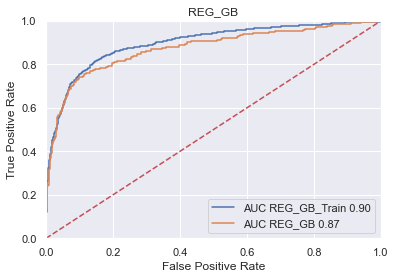

REG_GB CLASSIFICATION ACCURACY
REG_GB_Train  =  0.881501677852349
REG_GB  =  0.8800335570469798
------




In [ ]:
CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[GB_flag], Y_train[ TARGET_FLAG ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[GB_flag], Y_train[ TARGET_FLAG ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[GB_flag], Y_test[ TARGET_FLAG ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#### Loss Amount

In [ ]:
AMT = LinearRegression()
AMT = AMT.fit( W_train[GB_amt], Z_train[TARGET_LOSS] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[GB_amt], Z_train[TARGET_LOSS] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[GB_amt], Z_test[TARGET_LOSS] )

print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_GB RMSE ACCURACY
REG_GB_Train  =  4238.056494916955
REG_GB  =  4834.631645572038
------




In [ ]:
REG_GB_CLM_COEF = getCoefLogit( CLM, X_train[GB_flag] )
REG_GB_AMT_COEF = getCoefLinear( AMT, X_train[GB_amt] )

REG_GB_CLM = TEST_CLM.copy()
REG_GB_AMT = TEST_AMT.copy()


LOAN DEFAULT
---------
Total Variables:  11
INTERCEPT  =  -5.24430143027247
TRUNC_M_DEBTINC  =  2.738760511600896
TRUNC_IMP_DEBTINC  =  0.10578807558039724
TRUNC_IMP_DELINQ  =  0.7065760942356596
TRUNC_IMP_CLAGE  =  -0.00610884912245422
TRUNC_IMP_DEROG  =  0.7576642576894351
O_M_VALUE  =  3.5432677105315036
TRUNC_IMP_VALUE  =  5.686942832087663e-07
TRUNC_IMP_YOJ  =  -0.013075526298365439
TRUNC_IMP_CLNO  =  -0.016243098349593033
TRUNC_LOAN  =  -2.546639561948394e-06

LOSS AMOUNT
---------
Total Variables:  6
INTERCEPT  =  -13269.322689831992
TRUNC_LOAN  =  0.7957096877509179
TRUNC_IMP_CLNO  =  295.8661953290628
TRUNC_IMP_DEBTINC  =  198.11601519151213
TRUNC_M_DEBTINC  =  5813.596604342766
TRUNC_IMP_CLAGE  =  -25.63038798406322


### Regression Stepwise

In [ ]:
U_train = X_train[ vars_tree_flag ]
stepVarNames = list( U_train.columns.values )
maxCols = U_train.shape[1]
print(maxCols)

sfs = SFS( LogisticRegression( solver='newton-cg', max_iter=100 ),
           k_features=( 1, maxCols ),
           forward=True,
           floating=False,
           cv=3
           )
sfs.fit(U_train.values, Y_train[ TARGET_FLAG ].values)

10


SequentialFeatureSelector(cv=3,
                          estimator=LogisticRegression(solver='newton-cg'),
                          k_features=(1, 10))

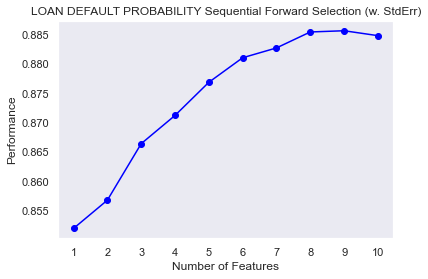

In [ ]:
theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
plt.title('LOAN DEFAULT PROBABILITY Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[ ['feature_names', 'avg_score'] ]
dfm.avg_score = dfm.avg_score.astype(float)

In [ ]:
print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[ maxIndex, ]
stepVars = stepVars.feature_names
print( stepVars )

 ................... 
argmax
feature_names    (0, 1, 2, 3, 4, 6, 7, 8, 9)
avg_score                           0.885697
Name: 9, dtype: object
 ................... 
('0', '1', '2', '3', '4', '6', '7', '8', '9')


In [ ]:
finalStepVars = []
for i in stepVars :
    index = int(i)
    try :
        theName = stepVarNames[ index ]
        finalStepVars.append( theName )
    except :
        pass

for i in finalStepVars :
    print(i)

U_train = X_train[ finalStepVars ]
U_test = X_test[ finalStepVars ]

TRUNC_IMP_CLAGE
TRUNC_M_DEBTINC
TRUNC_IMP_DEBTINC
O_M_VALUE
TRUNC_IMP_VALUE
TRUNC_M_DEROG
TRUNC_IMP_DEROG
O_IMP_DELINQ
TRUNC_IMP_DELINQ


In [ ]:
V_train = W_train[ GB_amt ]
stepVarNames = list( V_train.columns.values )
maxCols = V_train.shape[1]

sfs = SFS( LinearRegression(),
           k_features=( 1, maxCols ),
           forward=True,
           floating=False,
           scoring = 'r2',
           cv=5
           )
sfs.fit(V_train.values, Z_train[ TARGET_LOSS ].values)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(1, 5),
                          scoring='r2')

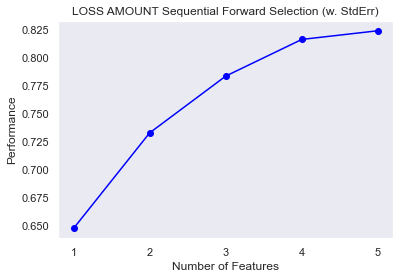

In [ ]:
theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
plt.title('LOSS AMOUNT Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[ ['feature_names', 'avg_score'] ]
dfm.avg_score = dfm.avg_score.astype(float)

In [ ]:
print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[ maxIndex, ]
stepVars = stepVars.feature_names
print( stepVars )

 ................... 
argmax
feature_names    (0, 1, 2, 3, 4)
avg_score               0.824332
Name: 5, dtype: object
 ................... 
('0', '1', '2', '3', '4')


In [ ]:
finalStepVars = []
for i in stepVars :
    index = int(i)
    try :
        theName = stepVarNames[ index ]
        finalStepVars.append( theName )
    except :
        pass

for i in finalStepVars :
    print(i)

V_train = W_train[ finalStepVars ]
V_test = W_test[ finalStepVars ]

TRUNC_LOAN
TRUNC_IMP_CLNO
TRUNC_IMP_DEBTINC
TRUNC_M_DEBTINC
TRUNC_IMP_CLAGE


### Regression

#### Loan Default Probability

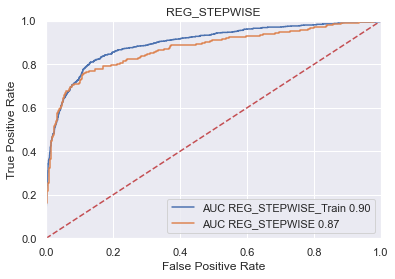

REG_STEPWISE CLASSIFICATION ACCURACY
REG_STEPWISE_Train  =  0.885486577181208
REG_STEPWISE  =  0.8842281879194631
------




In [ ]:
WHO = "REG_STEPWISE"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( U_train, Y_train[ TARGET_FLAG ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_FLAG ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_FLAG ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

#### Loss Amount

In [ ]:
AMT = LinearRegression()
AMT = AMT.fit( V_train, Z_train[TARGET_LOSS] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_LOSS] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_LOSS] )

print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_STEPWISE RMSE ACCURACY
REG_STEPWISE_Train  =  4238.056494916955
REG_STEPWISE  =  4834.631645572038
------




In [ ]:
REG_STEP_CLM_COEF = getCoefLogit( CLM, U_train )
REG_STEP_AMT_COEF = getCoefLinear( AMT, V_train )

REG_STEP_CLM = TEST_CLM.copy()
REG_STEP_AMT = TEST_AMT.copy()


LOAN DEFAULT
---------
Total Variables:  10
INTERCEPT  =  -5.353530813656673
TRUNC_IMP_CLAGE  =  -0.006837020088604123
TRUNC_M_DEBTINC  =  2.744201933282898
TRUNC_IMP_DEBTINC  =  0.10528069849571041
O_M_VALUE  =  3.709820349727899
TRUNC_IMP_VALUE  =  -8.007909005536421e-07
TRUNC_M_DEROG  =  -0.7852268386953548
TRUNC_IMP_DEROG  =  0.6922553233448552
O_IMP_DELINQ  =  2.0537201808929995
TRUNC_IMP_DELINQ  =  0.6176089000725961

LOSS AMOUNT
---------
Total Variables:  6
INTERCEPT  =  -13269.322689831992
TRUNC_LOAN  =  0.7957096877509179
TRUNC_IMP_CLNO  =  295.8661953290628
TRUNC_IMP_DEBTINC  =  198.11601519151213
TRUNC_M_DEBTINC  =  5813.596604342766
TRUNC_IMP_CLAGE  =  -25.63038798406322


### Regression Comparison

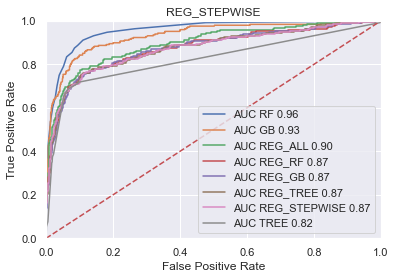

ALL CLASSIFICATION ACCURACY
RF  =  0.9119127516778524
GB  =  0.9060402684563759
REG_ALL  =  0.886744966442953
TREE  =  0.8859060402684564
REG_STEPWISE  =  0.8842281879194631
REG_GB  =  0.8800335570469798
REG_TREE  =  0.8800335570469798
REG_RF  =  0.87751677852349
------




In [ ]:
ALL_CLM = [ TREE_CLM, RF_CLM, GB_CLM, REG_ALL_CLM, REG_TREE_CLM, REG_RF_CLM, REG_GB_CLM, REG_STEP_CLM ]

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )
print_ROC_Curve( WHO, ALL_CLM ) 

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )
print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )

In [ ]:
ALL_AMT = [ TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT, REG_RF_AMT, REG_GB_AMT, REG_STEP_AMT ]
ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
print_Accuracy( "ALL DAMAGE MODEL ACCURACY", ALL_AMT )

ALL DAMAGE MODEL ACCURACY
GB  =  2794.947030828998
RF  =  3428.650015145327
REG_ALL  =  3615.1006384119664
REG_RF  =  4834.631645572038
REG_GB  =  4834.631645572038
REG_STEPWISE  =  4834.631645572038
REG_TREE  =  5063.987350451349
TREE  =  5713.237610480276
------


